In [2]:
import os

import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import plotly.io as pio
from catboost import CatBoostRegressor
pio.renderers.default = "iframe_connected"
from datetime import timedelta
plt.style.use('ggplot')


In [3]:
def weighted_spearmanr(y_true, y_pred):
    """
    Calculate the weighted Spearman correlation coefficient according to the formula in the appendix:
    1) Rank y_true and y_pred in descending order (rank=1 means the maximum value)
    2) Normalize the rank indices to [-1, 1], then square to obtain the weight w_i
    3) Calculate the correlation coefficient using the weighted Pearson formula
    """
    # number of samples
    n = len(y_true)
    # rank the true values in descending order (average method for handling ties)
    r_true = pd.Series(y_true).rank(ascending=False, method='average')
    # rank the predicted values in descending order (average method for handling ties)
    r_pred = pd.Series(y_pred).rank(ascending=False, method='average')
    
    # normalize the index i = rank - 1, mapped to [-1, 1]
    x = 2 * (r_true - 1) / (n - 1) - 1
    # weight w_i (the weight factor for each sample)
    w = x ** 2  
    
    # weighted mean
    w_sum = w.sum()
    mu_true = (w * r_true).sum() / w_sum
    mu_pred = (w * r_pred).sum() / w_sum
    
    # calculate the weighted covariance
    cov = (w * (r_true - mu_true) * (r_pred - mu_pred)).sum()
    # calculate the weighted variance of the true value rankings
    var_true = (w * (r_true - mu_true)**2).sum()
    # calculate the weighted variance of the predicted value rankings
    var_pred = (w * (r_pred - mu_pred)**2).sum()
    
    # return the weighted Spearman correlation coefficient
    return cov / np.sqrt(var_true * var_pred)

In [4]:
df = pd.read_parquet('../data/data_prologue.parquet')
tickers = set([
    'BTCUSDT',
    'ETHUSDT',
    'SOLUSDT',
    'GMTUSDT',
    'BNBUSDT',
    'DOGEUSDT'
] + list(df['ticker'].unique()[:20]))
# df = df[df['ticker'].isin(tickers)].reset_index(drop=True)

raw_columns = set(df.columns)

In [5]:
def add_return_features(
    df: pd.DataFrame,
    price_col: str = "vwap",
    ticker_col: str = "ticker",
    timestamp_col: str = "timestamp",
    bar_minutes: int = 15,
    lookbacks_hours = (6, 12, 24, 96, 168),
    max_lag: int = 3,
    prefix: str = "ret"
) -> pd.DataFrame:
    """
    Add simple return features over specified lookbacks (in hours) on 15m bars,
    plus up to `max_lag` lags for each return. Returns the updated DataFrame.

    Return definition (simple): r_t(w) = price_t / price_{t-w} - 1
    Lag definition: r_{t - k*w}(w), i.e., shift by k full windows (no leakage).

    Example columns created for 24h window:
      - ret_24h
      - ret_24h_lag1
      - ret_24h_lag2
    """
    # Ensure proper sort within each ticker
    if not pd.api.types.is_datetime64_any_dtype(df[timestamp_col]):
        df[timestamp_col] = pd.to_datetime(df[timestamp_col], utc=False)
    df = df.sort_values([ticker_col, timestamp_col])

    # Hours -> number of bars (15m bars)
    def hours_to_bars(h): 
        return int(h * 60 // bar_minutes)

    # Create base returns with pct_change over window
    for h in lookbacks_hours:
        window = hours_to_bars(h)
        col = f"{prefix}_{h}h"
        df[col] = (
            df.groupby(ticker_col)[price_col]
              .pct_change(periods=window)   # (p_t - p_{t-w})/p_{t-w}
        )

        # Lags: shift by k * window bars
        for k in range(1, max_lag + 1):
            df[f"{col}_lag{k}"] = (
                df.groupby(ticker_col)[col].shift(k * window)
            )

    return df

df = add_return_features(df)
return_features = set(df.columns) - raw_columns


In [6]:
def add_volume_features(
    df: pd.DataFrame,
    ticker_col: str = "ticker",
    timestamp_col: str = "timestamp",
    bar_minutes: int = 15,
    lookbacks_hours = (12, 24, 96, 168),
    max_lag: int = 2,
    base_cols = ("volume", "count", "buy_volume"),
    prefix: str = "volchg"
) -> pd.DataFrame:
    new_features = []

    if not pd.api.types.is_datetime64_any_dtype(df[timestamp_col]):
        df[timestamp_col] = pd.to_datetime(df[timestamp_col], utc=False)
    df.sort_values([ticker_col, timestamp_col], inplace=True)

    # Derived per-bar series (safe divisions)
    df["avg_trade_size"] = df["volume"] / df["count"].replace(0, np.nan) if {"volume","count"} <= set(df.columns) else np.nan
    df["buy_share_vol"] = df["buy_volume"] / df["volume"].replace(0, np.nan) if {"buy_volume","volume"} <= set(df.columns) else np.nan
    # df["buy_share_amt"] = df["buy_amount"] / df["amount"].replace(0, np.nan) if {"buy_amount","amount"} <= set(df.columns) else np.nan

    new_features += ['avg_trade_size', 'buy_share_vol']
    series_to_use = list(base_cols) + ["avg_trade_size", "buy_share_vol"]

    def hours_to_bars(h): 
        return int(h * 60 // bar_minutes)

    for h in lookbacks_hours:
        window = hours_to_bars(h)
        for col in series_to_use:
            if col not in df.columns:
                continue

            feat = f"{prefix}_{h}h__{col}"
            # element-wise change with transform (keeps original index!)
            df[feat] = (
                df.groupby(ticker_col)[col]
                  .transform(lambda s: s / s.shift(window) - 1.0)
            )
            new_features.append(feat)
            # lags by full window
            for k in range(1, max_lag + 1):
                df[f"{feat}_lag{k}"] = (
                    df.groupby(ticker_col)[feat].shift(k * window)
                )
                new_features.append(f"{feat}_lag{k}")

    return df, new_features

df, _ = add_volume_features(df)
volume_features = set(df.columns) - return_features - raw_columns


In [7]:
def add_regime_features(
    df: pd.DataFrame,
    ticker_col: str = "ticker",
    timestamp_col: str = "timestamp",
    price_col: str = "vwap",
    btc_ticker: str = "BTCUSDT",
    bar_minutes: int = 15,
    # Volatility windows (days)
    vol_short_days: int = 1,
    vol_long_days: int = 3,
    extra_vol_days = (7, 14),              # NEW: more horizons
    # Trend stability window (days)
    trend_stability_days: int = 3,
    # Breadth MA lengths (days)
    breadth_ma_days_list = (20, 50, 100),  # NEW: MA50 & MA100
    # BTC correlation windows (days)
    corr_days_list = (1, 3, 7, 14),
    # Trend slopes
    trend_slope_pairs = ((3, 1), (20, 10), (50, 20)),
    # Regime persistence lookback (days)
    persistence_days: int = 7
) -> pd.DataFrame:
    """
    Adds extended regime features:
      - Realized volatility: 1d,3d,7d,14d; ratios (1/7, 3/14); short-vol change
      - Trend slopes: (3/1), (20/10), (50/20) (raw & pct)
      - Trend stability (% positive bars over window)
      - Breadth: % tickers above MA20/50/100 per timestamp
      - BTC correlation (1d,3d,7d) per asset + market mean/std at each timestamp
      - Relative volatility: asset rv vs market avg vol and vs BTC vol (1d,7d)
      - Drawdowns: current & max over 14d/30d + vol-adjusted variants
      - Regime persistence: rolling share of being in high/low vol regimes over 7d
    """
    # --- basics ---
    if not pd.api.types.is_datetime64_any_dtype(df[timestamp_col]):
        df[timestamp_col] = pd.to_datetime(df[timestamp_col], utc=False)
    df.sort_values([ticker_col, timestamp_col], inplace=True)

    def days_to_bars(d):
        return int(d * (24 * 60 // bar_minutes))

    # --- 1-bar simple returns ---
    if "ret_1" not in df.columns:
        df["ret_1"] = df.groupby(ticker_col)[price_col].pct_change()

    # --- Volatility block (realized std over windows) ---
    vol_windows_days = sorted(set([vol_short_days, vol_long_days, *extra_vol_days]))
    for d in vol_windows_days:
        w = days_to_bars(d)
        df[f"rv_{d}d"] = (
            df.groupby(ticker_col)["ret_1"]
              .transform(lambda s: s.rolling(w, min_periods=w).std())
        )

    # Primary short/long ratio
    df["vol_ratio"] = df[f"rv_{vol_short_days}d"] / df[f"rv_{vol_long_days}d"]

    # Extra ratios: 1d/7d and 3d/14d if present
    if 1 in vol_windows_days and 7 in vol_windows_days:
        df["vol_ratio_1d_7d"] = df["rv_1d"] / df["rv_7d"]
    if 3 in vol_windows_days and 14 in vol_windows_days:
        df["vol_ratio_3d_14d"] = df["rv_3d"] / df["rv_14d"]

    # Short-vol change rate (e.g., 1d vol now / 1d vol 3d ago)
    shift_bars = days_to_bars(vol_long_days)  # reuse long window as change horizon
    df["vol_short_change"] = df[f"rv_{vol_short_days}d"] / df.groupby(ticker_col)[f"rv_{vol_short_days}d"].shift(shift_bars)

    # Volatility regimes (3-quantile bins) for short vol & vol_ratio
    def three_bin(series: pd.Series, labels=("low","mid","high")):
        s = series.copy()
        try:
            bins = pd.qcut(s.dropna(), q=3, labels=labels)
            s.loc[bins.index] = bins.astype(object)
        except Exception:
            q = s.dropna().quantile([1/3, 2/3]).values
            s = pd.cut(s, bins=[-np.inf, q[0], q[1], np.inf], labels=labels)
        return s.astype("category")

    df[f"rv_{vol_short_days}d_regime3"] = three_bin(df[f"rv_{vol_short_days}d"])
    df["vol_ratio_regime3"]            = three_bin(df["vol_ratio"])

    # --- Trend slopes (precompute MAs, then slopes) ---
    ma_days_unique = sorted({ma for ma, _ in trend_slope_pairs})
    for ma_days in ma_days_unique:
        w = days_to_bars(ma_days)
        df[f"ma_{ma_days}d"] = (
            df.groupby(ticker_col)[price_col]
              .transform(lambda s: s.rolling(w, min_periods=w).mean())
        )
    for ma_days, slope_days in trend_slope_pairs:
        ma_col = f"ma_{ma_days}d"
        shift_b = days_to_bars(slope_days)
        raw_col = f"{ma_col}_slope_{slope_days}d"
        pct_col = f"{raw_col}_pct"
        df[raw_col] = df[ma_col] - df.groupby(ticker_col)[ma_col].shift(shift_b)
        df[pct_col] = df[raw_col] / df[ma_col]

    # --- Trend stability ---
    win_stab = days_to_bars(trend_stability_days)
    df["__ret_pos_tmp"] = (df["ret_1"] > 0).astype(float)
    df[f"trend_stability_{trend_stability_days}d"] = (
        df.groupby(ticker_col)["__ret_pos_tmp"]
          .transform(lambda s: s.rolling(win_stab, min_periods=win_stab).mean())
    )
    df.drop(columns=["__ret_pos_tmp"], inplace=True)

    # --- Breadth (% above multiple MAs) ---
    for d in breadth_ma_days_list:
        w = days_to_bars(d)
        tmp_ma = (
            df.groupby(ticker_col)[price_col]
              .transform(lambda s: s.rolling(w, min_periods=w).mean())
        )
        flag = (df[price_col] > tmp_ma).astype(float)
        breadth = (
            df.groupby(timestamp_col)[flag.name]
              .apply(lambda x: x.values)  # just to keep index
        )  # dummy op to keep linter happy

        # compute % above MA_d per timestamp
        breadth_ts = (
            flag.groupby(df[timestamp_col]).mean()
                .rename(f"market_breadth_ma{d}d")
        )
        df = df.merge(breadth_ts, left_on=timestamp_col, right_index=True, how="left")

    # --- BTC correlation per asset + market cohesion/dispersion ---
    # BTC 1-bar returns aligned by timestamp
    btc_ret = (
        df.loc[df[ticker_col] == btc_ticker, [timestamp_col, "ret_1"]]
          .rename(columns={"ret_1": "btc_ret"})
    )
    df = df.merge(btc_ret, on=timestamp_col, how="left")

    for d in corr_days_list:
        w = days_to_bars(d)
        colname = f"corr_btc_{d}d"
        corr_series = (
            df.groupby(ticker_col)
              .apply(lambda g: g["ret_1"].rolling(w, min_periods=w).corr(g["btc_ret"]))
              .reset_index(level=0, drop=True)
        )
        df[colname] = corr_series
        # avoid trivial self-corr for BTC
        if (df[ticker_col] == btc_ticker).any():
            df.loc[df[ticker_col] == btc_ticker, colname] = np.nan

        # market mean/std of correlations at each timestamp (cohesion/dispersion)
        mean_ts = df.groupby(timestamp_col)[colname].mean().rename(f"market_mean_{colname}")
        std_ts  = df.groupby(timestamp_col)[colname].std(ddof=0).rename(f"market_std_{colname}")
        df = df.merge(mean_ts, left_on=timestamp_col, right_index=True, how="left")
        df = df.merge(std_ts,  left_on=timestamp_col, right_index=True, how="left")

    # --- Relative volatility: asset vs market avg, and vs BTC (for 1d & 7d) ---
    for d in (1, 7):
        rv_col = f"rv_{d}d"
        if rv_col in df.columns:
            m_avg = df.groupby(timestamp_col)[rv_col].mean().rename(f"market_mean_{rv_col}")
            df = df.merge(m_avg, left_on=timestamp_col, right_index=True, how="left")
            df[f"rel_{rv_col}_to_mkt"] = df[rv_col] / df[f"market_mean_{rv_col}"]

            # vs BTC vol
            btc_vol = (
                df.loc[df[ticker_col] == btc_ticker, [timestamp_col, rv_col]]
                  .drop_duplicates(subset=[timestamp_col])  # safe guard
                  .rename(columns={rv_col: f"btc_{rv_col}"})
            )
            df = df.merge(btc_vol, on=timestamp_col, how="left")
            df[f"rel_{rv_col}_to_btc"] = df[rv_col] / df[f"btc_{rv_col}"]

    # --- Drawdowns (per ticker) ---
    # Current drawdown vs rolling max, and max drawdown over window approximated
    for d in (14, 30):
        w = days_to_bars(d)
        roll_max = df.groupby(ticker_col)[price_col].transform(lambda s: s.rolling(w, min_periods=w).max())
        cur_dd = (df[price_col] / roll_max) - 1.0
        df[f"dd_cur_{d}d"] = cur_dd

        # max drawdown over the window ≈ rolling min of current drawdown
        max_dd = df.groupby(ticker_col)[f"dd_cur_{d}d"].transform(lambda s: s.rolling(w, min_periods=w).min())
        df[f"dd_max_{d}d"] = max_dd

        # vol-adjusted drawdown (divide by long vol to normalize)
        if f"rv_{vol_long_days}d" in df.columns:
            df[f"dd_cur_{d}d_voladj"] = df[f"dd_cur_{d}d"] / df[f"rv_{vol_long_days}d"]
            df[f"dd_max_{d}d_voladj"] = df[f"dd_max_{d}d"] / df[f"rv_{vol_long_days}d"]

    # --- Regime persistence (share of time in high/low over past N days) ---
    win_persist = days_to_bars(persistence_days)
    # ensure categories
    if not pd.api.types.is_categorical_dtype(df[f"rv_{vol_short_days}d_regime3"]):
        df[f"rv_{vol_short_days}d_regime3"] = df[f"rv_{vol_short_days}d_regime3"].astype("category")
    if not pd.api.types.is_categorical_dtype(df["vol_ratio_regime3"]):
        df["vol_ratio_regime3"] = df["vol_ratio_regime3"].astype("category")

    for col in [f"rv_{vol_short_days}d_regime3", "vol_ratio_regime3"]:
        # flags for high/low
        high_flag = (df[col] == "high").astype(float).rename(f"__{col}_high__")
        low_flag  = (df[col] == "low").astype(float).rename(f"__{col}_low__")

        df[high_flag.name] = high_flag
        df[low_flag.name]  = low_flag

        df[f"{col}_high_persist_{persistence_days}d"] = (
            df.groupby(ticker_col)[high_flag.name]
              .transform(lambda s: s.rolling(win_persist, min_periods=win_persist).mean())
        )
        df[f"{col}_low_persist_{persistence_days}d"] = (
            df.groupby(ticker_col)[low_flag.name]
              .transform(lambda s: s.rolling(win_persist, min_periods=win_persist).mean())
        )

        # clean temp flags
        df = df.drop(columns=[high_flag.name, low_flag.name])

    return df


df = add_regime_features(df)
regime_features = set(df.columns) - volume_features - return_features - raw_columns

/tmp/ipykernel_1772/1214913955.py:96: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/tmp/ipykernel_1772/1214913955.py:95: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/tmp/ipykernel_1772/1214913955.py:96: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/tmp/ipykernel_1772/1214913955.py:100: Performanc

### Invariant features

In [8]:
def add_tertile_regimes(df, cols, suffix="_regime3", labels=("low", "high")):
    for c in cols:
        s = df[c]
        try:
            bins = pd.qcut(s.dropna(), q=2, labels=labels)
            out = pd.Series(index=df.index, dtype="object")
            out.loc[bins.index] = bins.astype(object)
        except Exception:
            q = s.dropna().quantile([1 / 2]).values
            out = pd.cut(s, bins=[-np.inf, q[0], q[1], np.inf], labels=labels)
        df[f"{c}{suffix}"] = out.astype("category")
    return df

# example: bin correlation dispersion into a regime axis
regime_cols = [
            "market_breadth_ma100d",
            "market_mean_corr_btc_14d",
            "vol_ratio_3d_14d",
            "ma_50d_slope_20d_pct",
            ]

df = add_tertile_regimes(df, regime_cols)

/tmp/ipykernel_1772/2338155776.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/tmp/ipykernel_1772/2338155776.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/tmp/ipykernel_1772/2338155776.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/tmp/ipykernel_1772/2338155776.py:11: Performance

In [9]:
to_drop = ['timestamp', 'ticker', 'open', 'high', 'low', 'close', 'vwap',
           'amount', 'volume', 'count', 'buy_volume', 'buy_amount', 'target', 'id', 'target_rank', 'target_rank_smooth', 'prediction', 'target_class', 'is_test',
           'ticker_id']
features = [c for c in df.columns if c not in to_drop]
cat_features = df.select_dtypes(include="category").columns.tolist()
regime_determinators = [c + '_regime3' for c in regime_cols]


In [11]:
df = df.dropna()
df.sort_values(['ticker', 'timestamp'], inplace=True)
df.reset_index(drop=True, inplace=True)

In [12]:
def make_regime_id(df: pd.DataFrame, regime_cols):
    if isinstance(regime_cols, str):
        regime_cols = [regime_cols]
    for c in regime_cols:
        if not pd.api.types.is_categorical_dtype(df[c]):
            df[c] = df[c].astype("category")
    # build composite id; keep NaNs if any (we'll drop them later)
    regime_id = df[regime_cols].astype(str).agg("|".join, axis=1)
    # normalize "nan" strings to actual NaN
    regime_id = regime_id.replace("nan", np.nan)
    return regime_id.astype("category")

def invariant_feature_selection_by_regime(
    df: pd.DataFrame,
    features: list,
    cat_features=None,
    target_col: str = "target",
    regime_cols=("rv_1d_regime3", "vol_ratio_regime3"),
    topN: int = 60,
    min_freq: float = 0.6,
    min_rows_per_regime: int = 50,
    imp_type: str = "PredictionValuesChange",
    catboost_params: dict | None = None,
    verbose: bool = True
):
    if catboost_params is None:
        catboost_params = dict(
            loss_function="RMSE",
            learning_rate=0.02,
            depth=4,
            l2_leaf_reg=800,
            subsample=0.7,
            bootstrap_type="Bernoulli",
            random_strength=8,
            random_state=4,
            task_type="GPU",
            devices="0-3",
            verbose=False,
        )

    # Build regimes and show counts
    regime_id = make_regime_id(df, regime_cols)
    vc = regime_id.value_counts(dropna=True).sort_values(ascending=False)

    if verbose:
        print("Regime bucket sizes (top 10):")
        print(vc.head(10))

    # Drop NaN regimes and tiny buckets up front
    valid_mask = regime_id.notna()
    regime_id = regime_id[valid_mask]
    df_valid = df.loc[valid_mask]


    # Prepare data
    X_all = df_valid[features]
    y_all = df_valid[target_col].values

    # Build groups dict (regime -> row indices)
    groups = regime_id.groupby(regime_id).groups
    # Keep only regimes with enough rows
    big_groups = {rid: idx for rid, idx in groups.items() if len(idx) >= min_rows_per_regime}

    if verbose:
        print(f"Total regimes: {len(groups)} | Regimes ≥ {min_rows_per_regime} rows: {len(big_groups)}")

    if len(big_groups) == 0:
        raise ValueError(
            "No regimes passed the row-threshold. "
            "Try: reduce `min_rows_per_regime`, use fewer regime axes, or bin into fewer levels.\n"
            f"Largest bucket size was: {int(vc.iloc[0]) if len(vc)>0 else 0}"
        )

    per_regime_importances = []
    used_regimes = []

    for rid, idx in big_groups.items():
        try:
            X_r = X_all.loc[idx, :]
            # map to y_all positions (df_valid index aligns with X_all)
            y_r = y_all[X_all.index.get_indexer(idx)]

            model = CatBoostRegressor(**catboost_params)
            model.fit(X_r, y_r, cat_features=cat_features, verbose=False)

            vals = model.get_feature_importance(type=imp_type)
            s = pd.Series(vals, index=X_all.columns, name=str(rid))
            per_regime_importances.append(s)
            used_regimes.append(str(rid))
        except Exception as e:
            if verbose:
                print(f"[skip] regime {rid} failed: {e}")
            continue

    if len(per_regime_importances) == 0:
        raise ValueError("All eligible regimes failed to train. "
                         "Check that `cat_features` ⊆ `features`, and that features are numeric/valid.")

    imp_df = pd.concat(per_regime_importances, axis=1).fillna(0.0)
    imp_df.columns = [f"regime:{r}" for r in used_regimes]

    imp_df["mean_importance"] = imp_df.mean(axis=1)
    imp_df["std_importance"]  = imp_df.std(axis=1)

    rank_df = imp_df.drop(columns=["mean_importance", "std_importance"]).rank(
        ascending=False, method="first", axis=0
    )
    imp_df["freq_in_topN"] = (rank_df <= topN).mean(axis=1)

    imp_summary = imp_df.sort_values(["freq_in_topN", "mean_importance"], ascending=[False, False])
    suggested_features = imp_summary.index[imp_summary["freq_in_topN"] >= min_freq].tolist()

    if verbose:
        print(f"Regimes used: {len(used_regimes)} | Features kept: {len(suggested_features)} "
              f"(topN={topN}, min_freq={min_freq})")

    return {
        "importance_summary": imp_summary,
        "suggested_features": suggested_features,
        "used_regimes": used_regimes
    }


# ---- usage ----
res_inv = invariant_feature_selection_by_regime(
    df,
    features=features,
    cat_features=cat_features,
    target_col="target",
    regime_cols=regime_determinators,
    topN=60,
    min_freq=0.6,
    min_rows_per_regime=200
)
stable_feats = res_inv["suggested_features"]


Regime bucket sizes (top 10):
low|high|low|low       2801823
high|low|high|high     2703166
low|high|high|low      2230670
high|low|low|high      2201041
high|high|low|high     1461580
low|low|high|low       1421288
high|high|high|high    1247844
low|low|low|low        1207300
high|low|high|low      1069046
low|high|low|high       789675
Name: count, dtype: int64
Total regimes: 16 | Regimes ≥ 200 rows: 16
Regimes used: 16 | Features kept: 62 (topN=60, min_freq=0.6)


In [13]:
df.dropna(inplace=True)
df.sort_values(['ticker', 'timestamp'], inplace=True)
df.reset_index(drop=True, inplace=True)

In [14]:
stable_feats

['market_std_corr_btc_14d',
 'market_mean_corr_btc_14d',
 'btc_rv_7d',
 'market_mean_rv_7d',
 'market_mean_corr_btc_7d',
 'market_breadth_ma100d',
 'market_std_corr_btc_7d',
 'market_breadth_ma50d',
 'market_std_corr_btc_3d',
 'market_mean_rv_1d',
 'market_breadth_ma20d',
 'btc_rv_1d',
 'market_mean_corr_btc_3d',
 'market_mean_corr_btc_1d',
 'market_std_corr_btc_1d',
 'ret_12h',
 'ret_168h',
 'ret_6h',
 'ret_96h',
 'ma_3d_slope_1d_pct',
 'ret_24h',
 'ret_168h_lag3',
 'ret_96h_lag2',
 'dd_max_14d',
 'ma_50d_slope_20d_pct',
 'ret_168h_lag1',
 'ma_20d_slope_10d_pct',
 'rv_1d_regime3_high_persist_7d',
 'ret_168h_lag2',
 'rv_3d',
 'rv_14d',
 'dd_max_30d',
 'vol_short_change',
 'ret_24h_lag3',
 'ret_24h_lag2',
 'ret_24h_lag1',
 'dd_max_14d_voladj',
 'vol_ratio_regime3',
 'rel_rv_7d_to_mkt',
 'corr_btc_14d',
 'rel_rv_7d_to_btc',
 'vol_ratio_regime3_high_persist_7d',
 'ret_96h_lag3',
 'dd_max_30d_voladj',
 'rv_7d',
 'dd_cur_30d',
 'dd_cur_14d',
 'rv_1d',
 'vol_ratio_3d_14d',
 'rel_rv_1d_to_mkt

### Direct Model

In [52]:
exclude_cols = ['timestamp', 'ticker', 'open', 'high', 'low', 'close', 'vwap', 'amount',
                'volume', 'count', 'buy_volume', 'buy_amount', 'target']

feats = [c for c in df.columns if c not in exclude_cols]
regime_determinators
# cat_feats = [c for c in df.columns if 'regime' in c]
cat_feats = [c for c in df.select_dtypes('category').columns.to_list() if c in stable_feats or c in regime_determinators]

In [53]:
for c in regime_determinators:
    if c not in stable_feats:
        stable_feats.append(c)

In [ ]:
catboost_params = dict(
        loss_function="RMSE",
        iterations=5000,
        learning_rate=0.03,
        depth=3,
        l2_leaf_reg=1000,
        random_strength=3,
        random_state=4,
        task_type="GPU",
        devices="0-3",
        eval_metric="RMSE",
        # early_stopping_rounds=2000,
        bootstrap_type="Bernoulli",
        verbose=False,
    )

final_model = CatBoostRegressor(
    **catboost_params
)
final_model.fit(
    # df[list(return_features)],
    df[stable_feats],
    df["target"],
    cat_features=cat_feats,
    verbose=1000
)

0:	learn: 0.0640761	total: 52.4ms	remaining: 2m 37s
1000:	learn: 0.0570831	total: 42.7s	remaining: 1m 25s
2000:	learn: 0.0545723	total: 1m 25s	remaining: 42.8s
2999:	learn: 0.0528293	total: 2m 8s	remaining: 0us


In [55]:
valdf = pd.read_parquet('../data/validation.parquet')
valdf = valdf[valdf['timestamp'] < '2025-05-30']

valdf = add_return_features(valdf)
valdf, _ = add_volume_features(valdf)
valdf = add_regime_features(valdf)

/tmp/ipykernel_1772/1214913955.py:95: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/tmp/ipykernel_1772/1214913955.py:96: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/tmp/ipykernel_1772/1214913955.py:95: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/tmp/ipykernel_1772/1214913955.py:96: Performance

In [56]:
valdf = valdf.dropna()
valdf = valdf.sort_values(['ticker', 'timestamp']).reset_index(drop=True)

In [57]:
valdf['timestamp'].min(), valdf['timestamp'].max()

(Timestamp('2025-03-11 23:45:00'), Timestamp('2025-05-29 23:45:00'))

In [31]:
valdf = valdf[valdf['timestamp'] < '2025-04-01'].reset_index(drop=True)

In [ ]:
y_pred = final_model.predict(df[stable_feats])
print('Train score: ', weighted_spearmanr(df['target'], y_pred))


y_val = final_model.predict(valdf[stable_feats])
print('Validation score: ', weighted_spearmanr(valdf['target'], y_val))

In [44]:
val_scores = []
dates = []
time_step = timedelta(days=1)
cur = valdf['timestamp'].max()

while cur > valdf['timestamp'].min():
    valdata = valdf[valdf['timestamp'] <= cur].copy()
    valdata.sort_values(['ticker', 'timestamp'], inplace=True)
    valdata.reset_index(drop=True, inplace=True)
    y_val = final_model.predict(valdata[stable_feats])
    score = weighted_spearmanr(valdata['target'], y_val)
    val_scores.append(score)
    dates.append(cur)
    cur -= time_step


Text(0, 0.5, 'Score')

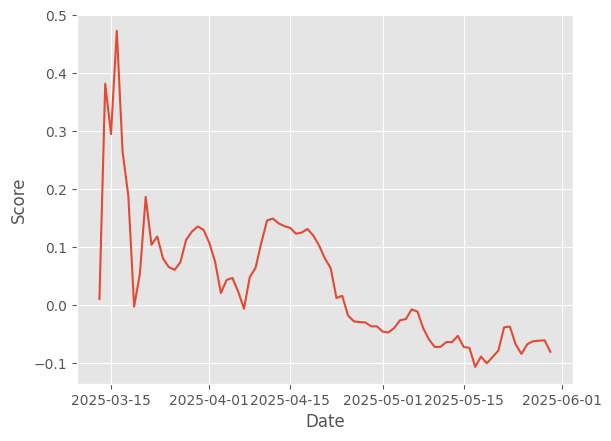

In [45]:
plt.plot(dates, val_scores)
plt.xlabel('Date')
plt.ylabel('Score')

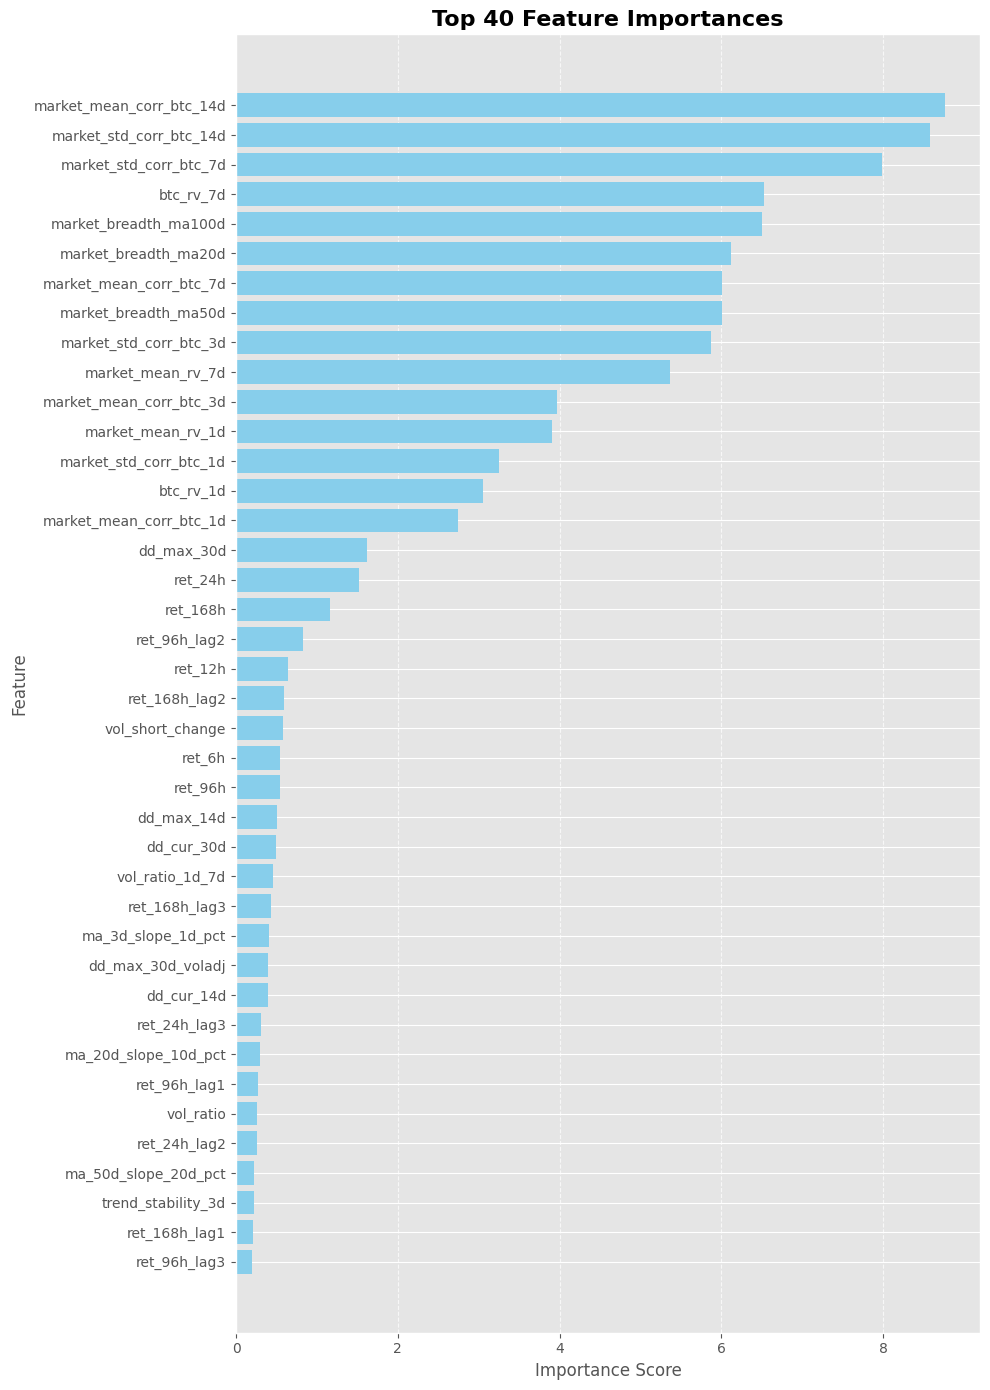

In [26]:
feature_importances = final_model.get_feature_importance()
feature_names = final_model.feature_names_

# Put into a DataFrame for easy sorting
fi_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": feature_importances
}).sort_values("Importance", ascending=False)

# Select top 50
top50 = fi_df.head(40)

# Plot
plt.figure(figsize=(10, 14))
plt.barh(top50["Feature"], top50["Importance"], color="skyblue")
plt.gca().invert_yaxis()  # highest importance at top
plt.title("Top 40 Feature Importances", fontsize=16, fontweight="bold")
plt.xlabel("Importance Score", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()
